In [1]:
%cd ..

d:\~Perso\Etudes\DAC\NeuralNetworksDIY


# Débruitage de données bruitées grâce à notre auto-encodeur


In [2]:
import os
import pickle
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from skimage import io, transform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


np.random.seed(42)


def load_data(rootdir, class_list=None, trim: float = 0.5):
    def normalize_batch_image(X):
        mn = np.min(X)
        mx = np.max(X)
        X_norm = (X - mn) * (1.0 / (mx - mn))
        return X_norm

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    # Filtering requested class
    if class_list:
        train = train[train["label"].isin(class_list)]
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    # Filtering requested class
    if class_list:
        test = test[test["label"].isin(class_list)]
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = y_train[:trim_train]
    y_test = y_test[:trim_test]

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir, trim=0.5)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


def load_model(path):
    with open(path, "rb") as f:
        optimizer = pickle.load(f)
        net = optimizer.network
        loss_long_df = pd.melt(
            optimizer.train_df,
            id_vars="epoch",
            value_vars=["loss_test", "loss_train"],
            value_name="loss",
            var_name="during",
        ).replace({"loss_test": "test", "loss_train": "train"})
    return optimizer, net, loss_long_df


d:\~Perso\Etudes\DAC\NeuralNetworksDIY\src\encapsulation.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
optimizer_simple, net_simple, loss_long_df_simple = load_model(
    "./models/fashion-mnist_30_epoch_simple_net.pkl"
)
optimizer_cplx, net_medium, loss_long_df_medium = load_model(
    "./models/fashion-mnist_30_epoch_medium_net.pkl"
)
optimizer_big, net_big, loss_long_df_big = load_model(
    "./models/fashion-mnist_30_epoch_big_net.pkl"
)


In [12]:
def noise(array, noise_factor=0.4):
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)


def display(original_images, noisy_images, net):
    n = 10

    decoded_imgs = net.forward(noisy_images)

    indices = [np.nonzero(y_test == i)[0][1] for i in range(n)]
    images1 = original_images[indices, :]
    images2 = noisy_images[indices, :]
    images3 = decoded_imgs[indices, :]

    fig, ax = plt.subplots(nrows=3, ncols=n, figsize=(20, 8))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax[0, i].imshow(image1.reshape(28, 28), cmap="gray")
        ax[0, i].set_axis_off()

        ax[1, i].imshow(image2.reshape(28, 28), cmap="gray")
        ax[1, i].set_axis_off()

        ax[2, i].imshow(image3.reshape(28, 28), cmap="gray")
        ax[2, i].set_axis_off()

    plt.tight_layout()
    plt.show()


noisy_test_data = noise(X_test, 0.2)


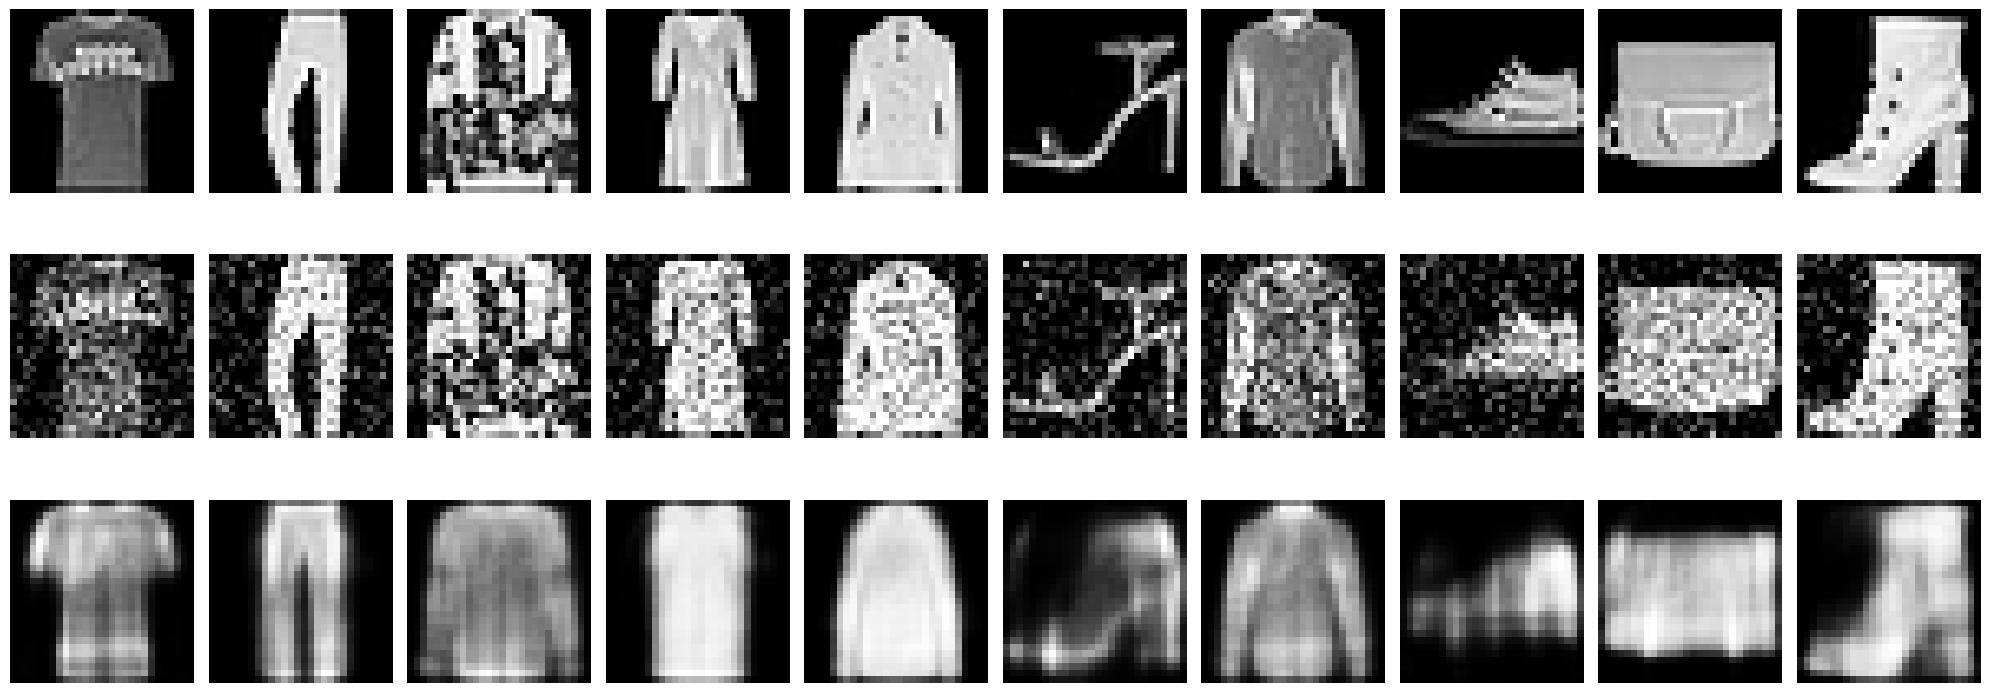

In [9]:
display(X_test, noisy_test_data, net_simple)


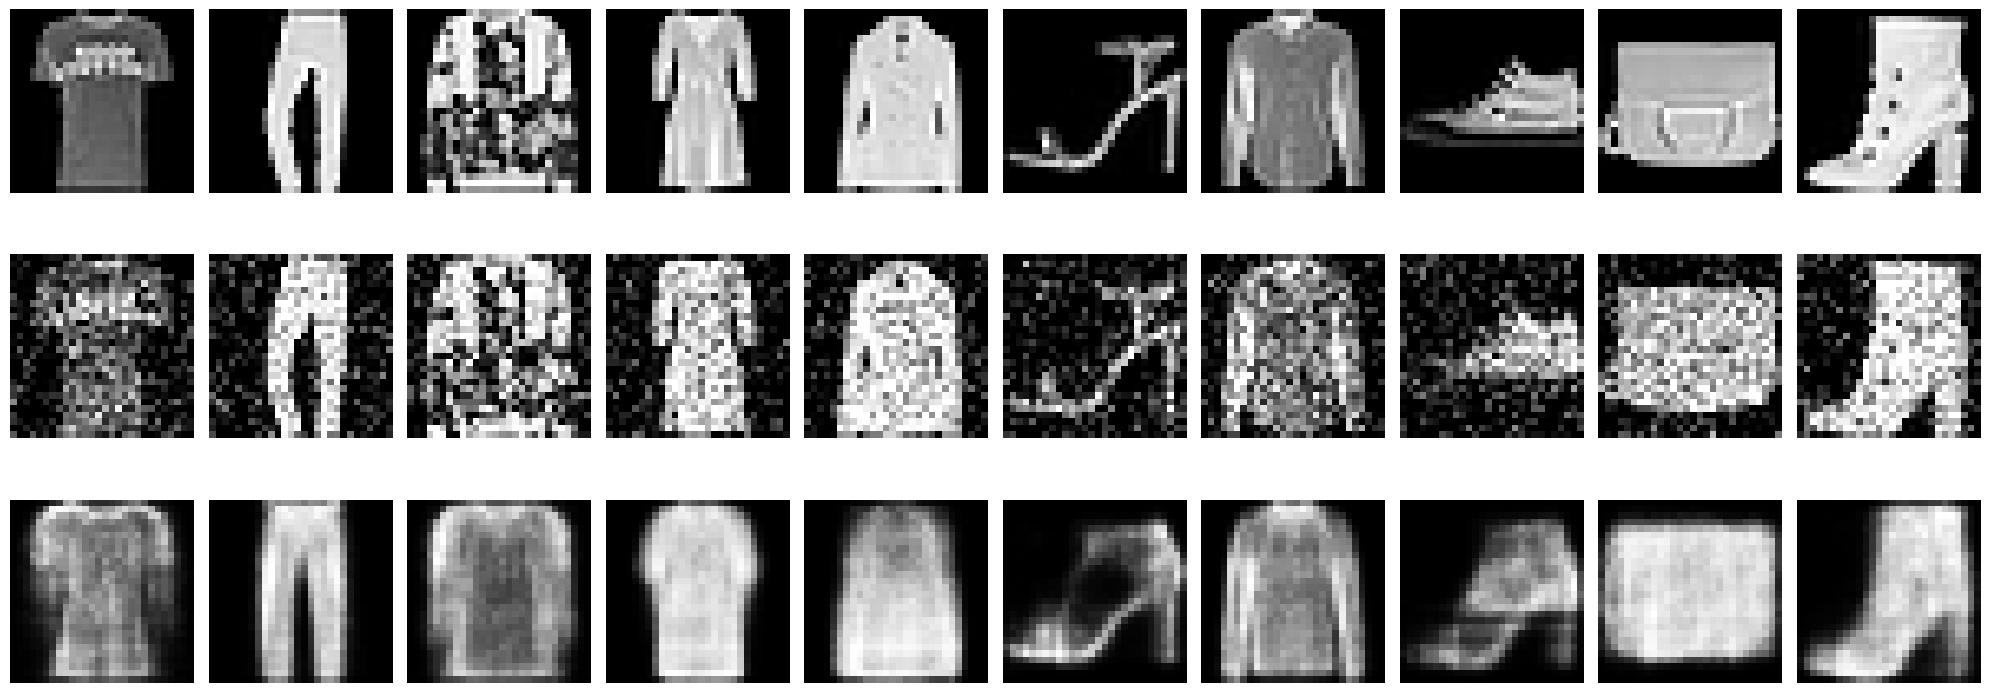

In [11]:
display(X_test, noisy_test_data, net_medium)


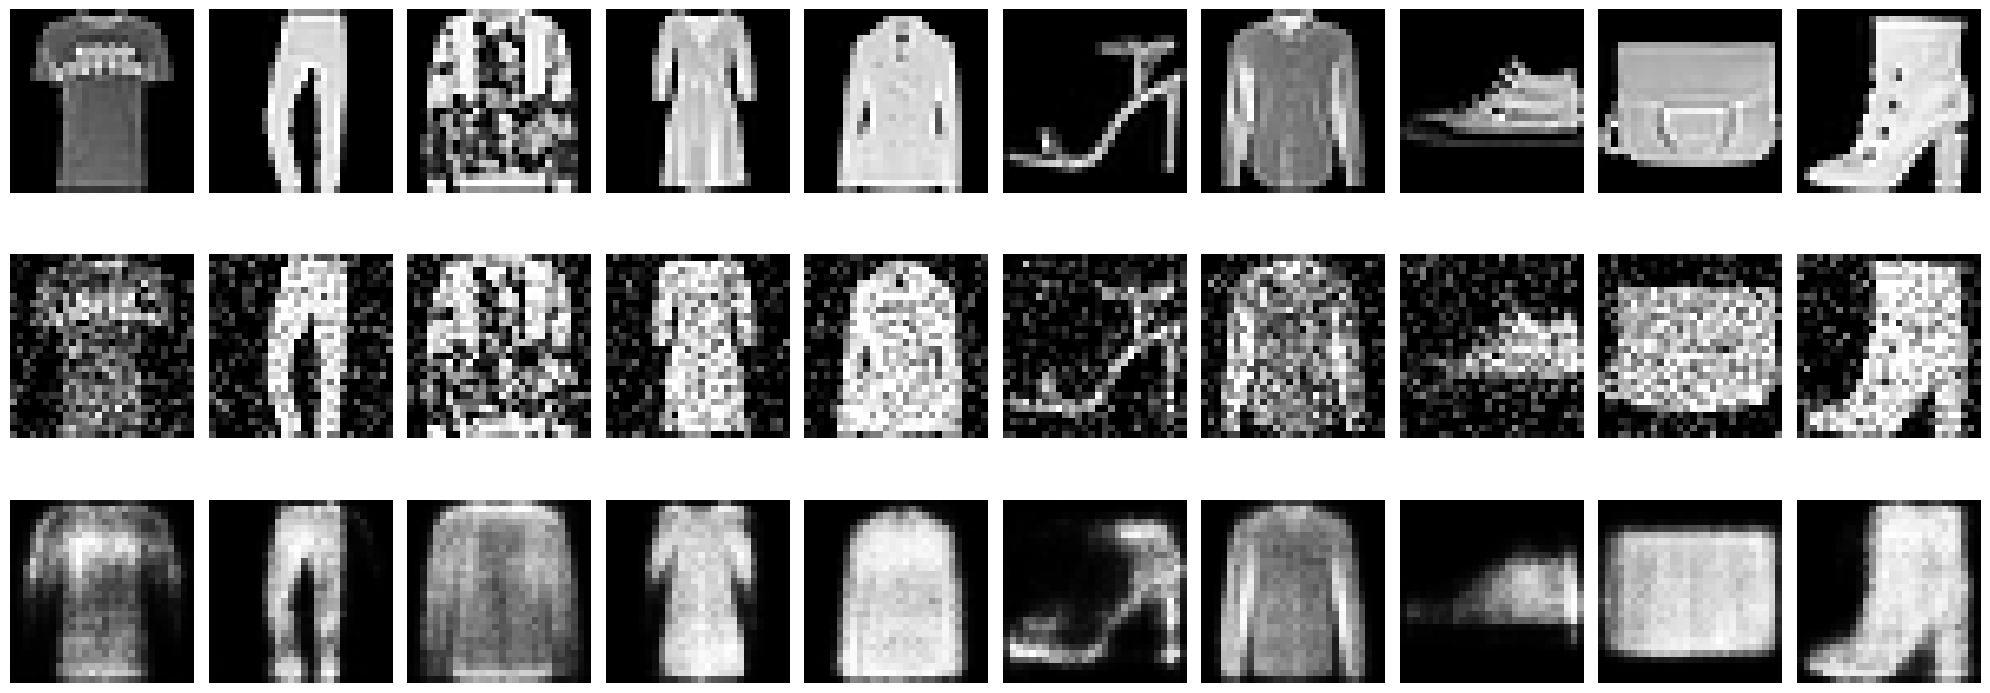

In [13]:
display(X_test, noisy_test_data, net_big)


In [ ]:
def display_simple(original_images):
    titres = ["simple", "complexe", "très complexe"]
    indice = np.random.randint(len(original_images), size=1)
    # indice = np.random.choice(np.nonzero(y_test == 4)[0])

    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14, 10))
    for row, noise_factor in enumerate([0.2, 0.4, 0.6, 0.8]):
        noisy_images = noise(original_images, noise_factor)
        image1 = original_images[indice, :]
        image2 = noisy_images[indice, :]

        ax[row, 0].imshow(image1.reshape(28, 28), cmap="gray")
        ax[row, 0].set_title(f"Original")
        ax[row, 0].set_axis_off()
        ax[row, 1].imshow(image2.reshape(28, 28), cmap="gray")
        ax[row, 1].set_title(f"Bruit gaussien de {noise_factor * 100} %")
        ax[row, 1].set_axis_off()

        for col, net in enumerate([net_simple, net_medium, net_big]):
            decoded_imgs = net.forward(noisy_images)
            image3 = decoded_imgs[indice, :]
            ax[row, 2 + col].imshow(image3.reshape(28, 28), cmap="gray")
            ax[row, 2 + col].set_title(f"Réseau {titres[col]}")
            ax[row, 2 + col].set_axis_off()

    plt.tight_layout()
    # plt.savefig("./reports/src/reconstruct_noisy_.pdf", dpi=100, bbox_inches="tight")
    plt.show()


display_simple(X_test)
